In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
pd.set_option("max_columns",None)
plt.style.use("ggplot")

In [2]:
# The bikeshare project is aimed to predict the demand for bicycles in a bikeshare system.
df = pd.read_csv("./data/hour.csv")
df.shape

(17379, 17)

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
vals = scaler.fit_transform(df[['demand']])
pd.DataFrame(vals).describe()
# plt.hist(vals)

,0
count,1.737900e+04
mean,-1.054836e-16
std,1.000029e+00
min,-1.039037e+00
25%,-8.240221e-01
50%,-2.616742e-01
75%,5.046626e-01
max,4.341860e+00


In [4]:
df.isnull().sum()

index         0
date          0
season        0
year          0
month         0
hour          0
holiday       0
weekday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
demand        0
dtype: int64

In [5]:
df.head()

,index,date,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,demand
0,1,01-01-2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01-01-2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01-01-2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01-01-2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01-01-2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Prelim Analysis and Feature Selection

Here, we analyze the data and drop obvious features

In [6]:
# we drop casual and registered because casual + registered = demand
# drop index and date because they do not help with predictions
df.drop(["index","date","casual","registered"],axis=1,inplace=True)

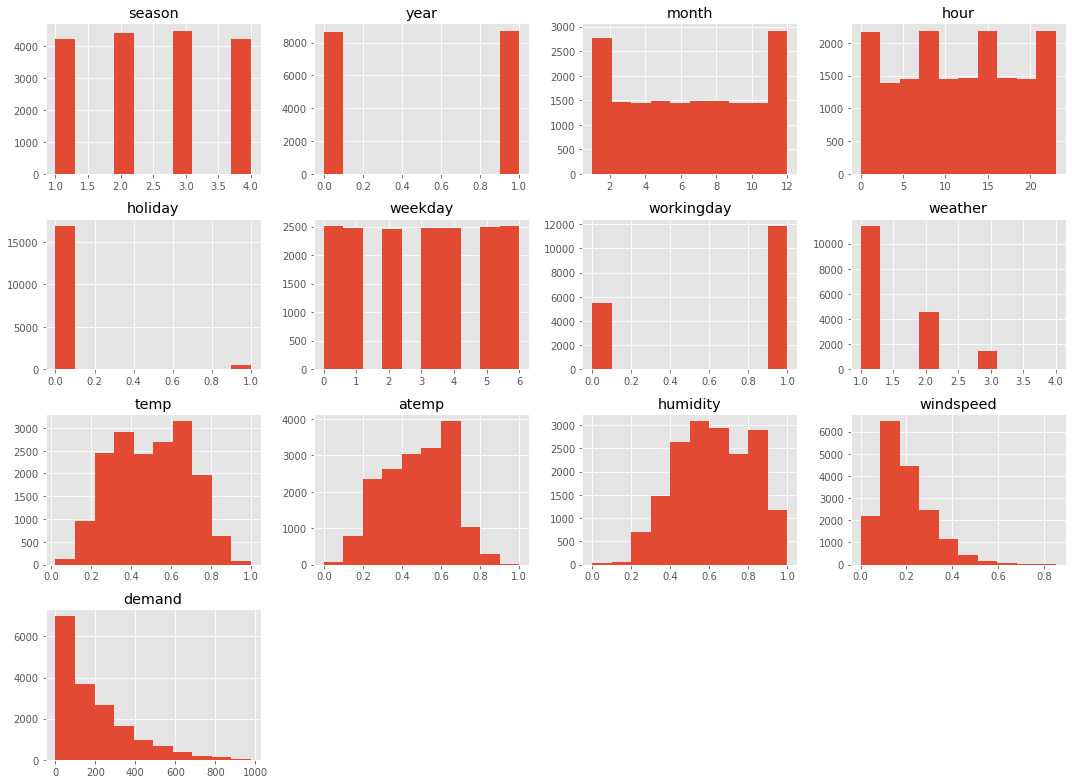

In [7]:
## Check distributions of the data
df.hist(figsize=(15,11));
plt.tight_layout()
plt.show()

# Demand is not normally distributed
# temp, atemp, humidity, windspeed are fairly distributed to some extent

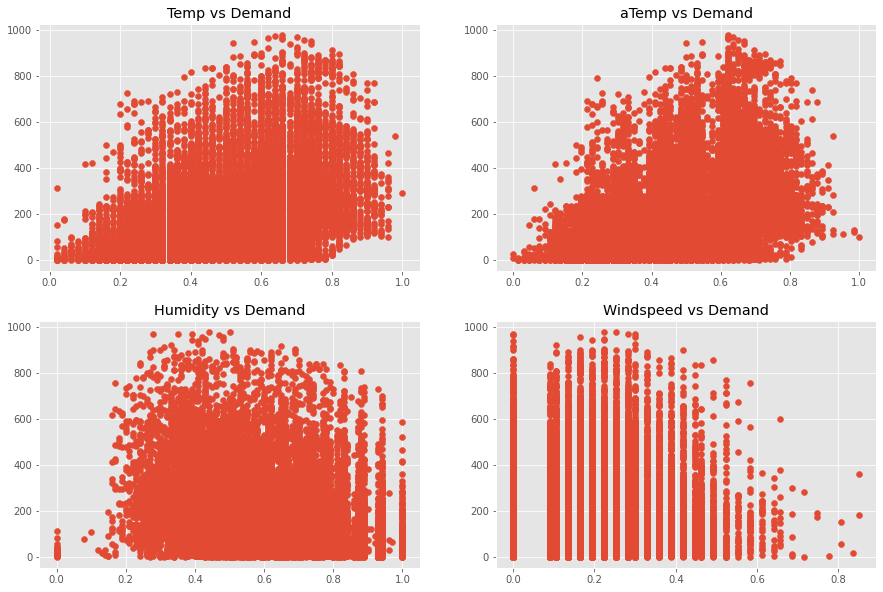

In [8]:
f = plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.title("Temp vs Demand")
plt.scatter(df["temp"],df["demand"]);


plt.subplot(2,2,2)
plt.title("aTemp vs Demand")
plt.scatter(df["atemp"],df["demand"]);


plt.subplot(2,2,3)
plt.title("Humidity vs Demand")
plt.scatter(df["humidity"],df["demand"]);


plt.subplot(2,2,4)
plt.title("Windspeed vs Demand")
plt.scatter(df["windspeed"],df["demand"]);

# We notice that the temp and atemp have very similar distributions
# We notice that around after 0.3 in windspeed, the demand is affected and goes down
# Humidity is does not seem to have any correlation with demand, but more analysis is needed

In [9]:
df.dtypes

season          int64
year            int64
month           int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity      float64
windspeed     float64
demand          int64
dtype: object

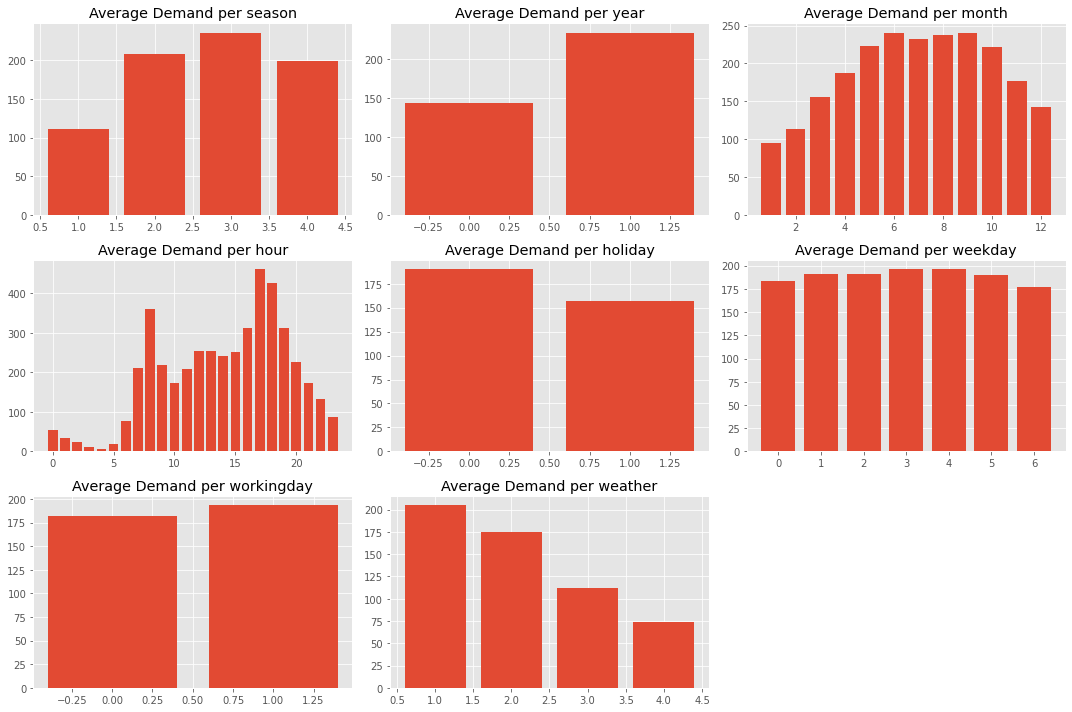

In [10]:
# Plotting for categorical features
f = plt.figure(figsize=(15,10))

index = 1
for i in ["season","year","month","hour","holiday","weekday","workingday","weather"]:
    plt.subplot(3,3,index)
    plt.title(f"Average Demand per {i}")
    plt.bar(df[i].unique(), df.groupby(i).mean().demand)
    index+=1
    plt.tight_layout()

We notice that demand varies depending on season. Lower during spring and higher as the seasons change<br><br>
Demand per year should be dropped even though it shows an upward trend since we do not have enough info <br><br>
Huge variation depending on month. Peak found in between 6 and 8th month<br><br>
Demand is lower in the morning and higher in afternoon and night. It starts to pick up during 5 and peaks at around 8am. Drops and remains steady until 3pm. Picks up and drops until 5pm. Past 5pm, it drops steadily.<br><br>
Demand is higher during holiday period. Though not much, there is still some variation. <br><br>
Average demand per weekday does not seem to vary much. Can drop this feature <br><br>
Working day does not seem to have much variation. We can drop this variable. Even though we think people might be using bicycles to commnute to work, they could be renting for fun.<br><br>
Weather seems to show good trend. When there is no rain, demand is very high and vice versa. We keep this variable

### Summary of data visualization findings

<ul>
    <li>Dependent variable of demand is not normally distributed. Have to use some transformation to normalize it.</li>
    <li>Temperature and aTemp appears to have correlation with demand.</li>
    <li>Plot for temp and atemp almost identical</li>
    <li>Humidity and wind speed affect demand but more statistical analysis is needed</li>
    <li>There is variation in demand based on season, month, holiday, hour and weather</li>
    <li>There is no significant change in average demand due to weekday or working day</li>
    <li>Year wise growth is not considered due to a limited number of years</li>
</ul>


### Check for outliers

In [11]:
df['demand'].describe()
# Look at the quantiles. 50% of the data between 25% and 75%

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: demand, dtype: float64

In [12]:
# print a list of quantile values
# 5% of the demand is below 5.00, 1% of the time the demand is above 782.22
df['demand'].quantile([0.05,0.1,0.15,0.8,0.85,0.9,0.95,0.99])

0.05      5.00
0.10      9.00
0.15     16.00
0.80    321.00
0.85    376.00
0.90    451.20
0.95    563.10
0.99    782.22
Name: demand, dtype: float64

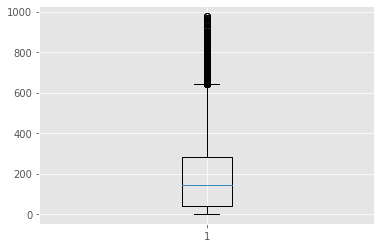

In [13]:
plt.boxplot(df['demand']);

### Test multicollinearity

Here, we see the temp and atemp have near perfect linear correlation. This violates multicollinearity, so we can drop the atemp feature.
<br>
For windspeed, we notice that it does not have a high linear correlation with demand, so we drop it. 
<br>
For the rest of the variables, we can keep them. <br>


In [14]:
corr = df[['temp','atemp','humidity','windspeed','demand']].corr()
corr

,temp,atemp,humidity,windspeed,demand
temp,1.000000,0.987672,-0.069881,-0.023125,0.404772
atemp,0.987672,1.000000,-0.051918,-0.062336,0.400929
humidity,-0.069881,-0.051918,1.000000,-0.290105,-0.322911
windspeed,-0.023125,-0.062336,-0.290105,1.000000,0.093234
demand,0.404772,0.400929,-0.322911,0.093234,1.000000


In [15]:
df.drop(['atemp','year','workingday','weekday','windspeed'],inplace=True,axis=1)

### Test Autocorrelation

If there is autocorrelation present, we split the column up into different columns. When we use the multiple columns in predictions <b>AS FEATURES</b>, we will solve the problem of autocorrelation. 

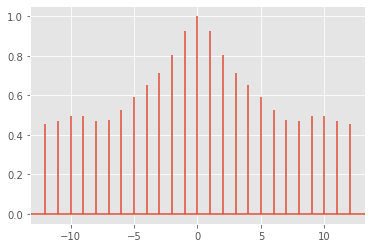

In [16]:
demand = pd.to_numeric(df['demand'],downcast='float')
plt.acorr(demand,maxlags=12);

# We notice that there is high correlation up to timelag=5

In [17]:
t_1 = df['demand'].shift(+1).to_frame()
t_1.columns = ['t-1']
t_2 = df['demand'].shift(+2).to_frame()
t_2.columns = ['t-2']
t_3 = df['demand'].shift(+3).to_frame()
t_3.columns = ['t-3']
df = pd.concat([df, t_1,t_2,t_3],axis=1)
df

,season,month,hour,holiday,weather,temp,humidity,demand,t-1,t-2,t-3
0,1,1,0,0,1,0.24,0.81,16,NaN,NaN,NaN
1,1,1,1,0,1,0.22,0.80,40,16.0,NaN,NaN
2,1,1,2,0,1,0.22,0.80,32,40.0,16.0,NaN
3,1,1,3,0,1,0.24,0.75,13,32.0,40.0,16.0
4,1,1,4,0,1,0.24,0.75,1,13.0,32.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...
17374,1,12,19,0,2,0.26,0.60,119,122.0,164.0,214.0
17375,1,12,20,0,2,0.26,0.60,89,119.0,122.0,164.0
17376,1,12,21,0,1,0.26,0.60,90,89.0,119.0,122.0
17377,1,12,22,0,1,0.26,0.56,61,90.0,89.0,119.0


In [18]:
df.isnull().sum()

season      0
month       0
hour        0
holiday     0
weather     0
temp        0
humidity    0
demand      0
t-1         1
t-2         2
t-3         3
dtype: int64

In [19]:
df.dropna(inplace=True)
df.isnull().sum()

season      0
month       0
hour        0
holiday     0
weather     0
temp        0
humidity    0
demand      0
t-1         0
t-2         0
t-3         0
dtype: int64

### Normalizing the target var

We notice that the demand resembles a log-normal distribution.<br>
If we log each value, we will get a normal distribution.<br>
<b>Note that applying standardscaler or minmax scaler does not change the shape of the distribution, but only changes the scale of it</b>

(array([ 158.,  432.,  925., 1033., 1280., 1596., 2561., 4230., 3780.,
        1381.]),
 array([0.        , 0.68844867, 1.37689733, 2.065346  , 2.75379466,
        3.44224333, 4.13069199, 4.81914066, 5.50758932, 6.19603799,
        6.88448665]),
 <BarContainer object of 10 artists>)

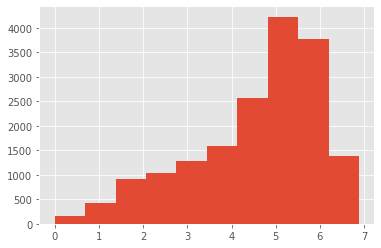

In [20]:
normalized_demand = np.log(df['demand'])
plt.hist(normalized_demand)

# The distribution is skewed due to outliers, but is noramlly distributed now

In [21]:
df['demand'] = np.log(df['demand'])

### Creating Dummy Variables

In [22]:
df[['season','holiday','weather','month','hour']] = df[['season','holiday','weather','month','hour']].astype('category')
dummy_df = pd.get_dummies(df,drop_first=True)
dummy_df

,temp,humidity,demand,t-1,t-2,t-3,season_2,season_3,season_4,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,holiday_1,weather_2,weather_3,weather_4
3,0.24,0.75,2.564949,32.0,40.0,16.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.24,0.75,0.000000,13.0,32.0,40.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.24,0.75,0.000000,1.0,13.0,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
6,0.22,0.80,0.693147,1.0,1.0,13.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0.20,0.86,1.098612,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0.26,0.60,4.779123,122.0,164.0,214.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
17375,0.26,0.60,4.488636,119.0,122.0,164.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
17376,0.26,0.60,4.499810,89.0,119.0,122.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
17377,0.26,0.56,4.110874,90.0,89.0,119.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [24]:
x_train, x_test, y_train, y_test = train_test_split(dummy_df, dummy_df['demand'],random_state=1234)
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [25]:
pred = model.predict(x_test)
pred

array([6.36818719, 4.74493213, 5.69373214, ..., 5.0937502 , 5.7235851 ,
       2.19722458])

In [26]:
mse = mean_squared_error(pred, y_test)

In [27]:
r2_train = model.score(x_train, y_train)
r2_test  = model.score(x_test, y_test)
r2_train, r2_test

(1.0, 1.0)

In [28]:
np.sqrt(mse)

5.542054453772826e-14

In [29]:
# Calculate RMSLE
y_test_e = []
y_pred_e = []

import math
for i in range(0, len(y_test)):
    y_test_e.append(math.exp(y_test.values[i]))
    y_pred_e.append(math.exp(pred[i]))


log_sq_sum = 0.0

for i in range(0, len(y_test_e)):
    log_a = math.log(y_test_e[i] + 1)
    log_p = math.log(y_pred_e[i] + 1)
    log_diff = (log_p - log_a)**2
    log_sq_sum = log_sq_sum + log_diff

rmsle = math.sqrt(log_sq_sum/len(y_test))

In [30]:
rmsle

5.500766796066944e-14